In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2024-01-01")
data = data[['Close']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [6]:
X_train_lr = np.arange(train_size).reshape(-1, 1)
y_train_lr = train_data.flatten()
X_test_lr = np.arange(train_size, len(scaled_data)).reshape(-1, 1)
y_test_lr = test_data.flatten()

In [7]:
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)
lr_predictions = lr_model.predict(X_test_lr)

In [8]:
lr_predictions = scaler.inverse_transform(lr_predictions.reshape(-1, 1))

In [9]:
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [10]:

seq_length = 50
X_train_lstm, y_train_lstm = create_sequences(train_data, seq_length)
X_test_lstm, y_test_lstm = create_sequences(test_data, seq_length)

In [11]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, verbose=1)

c:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0971
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0025
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0020
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0018
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0023
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0019
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0015
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0016
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0016
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0013
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0015
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0012
Epoch 13/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0012
Epoch 14/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0013
Epoch 15/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0011
Epo

In [13]:
lr_mse = mean_squared_error(y_test_lr[:len(lr_predictions)], lr_predictions)
lstm_mse = mean_squared_error(y_test_lstm[:len(lstm_predictions)], lstm_predictions)

print(f"Linear Regression MSE: {lr_mse}")
print(f"LSTM MSE: {lstm_mse}")


Linear Regression MSE: 32514.64211680066
LSTM MSE: 31468.106877385027


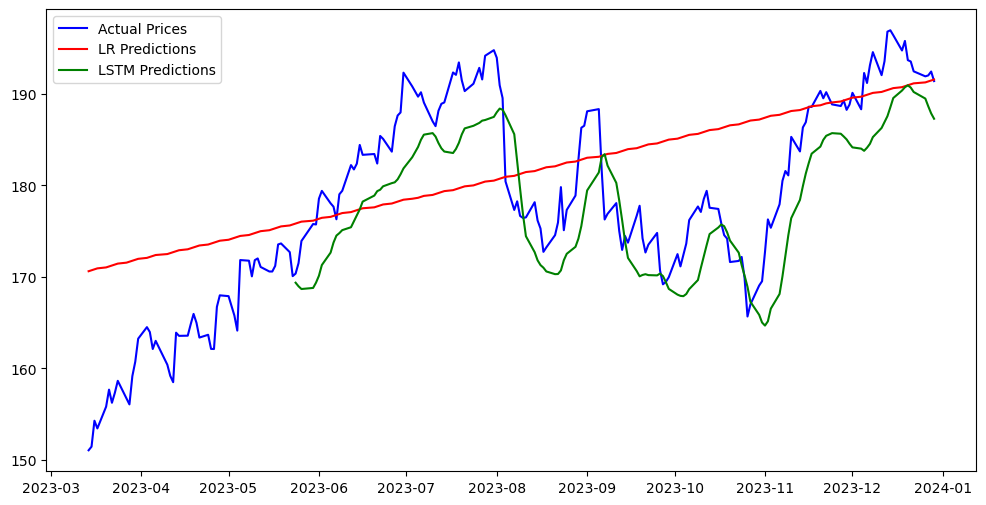

In [14]:
plt.figure(figsize=(12,6))
plt.plot(data.index[train_size:], scaler.inverse_transform(test_data), label="Actual Prices", color="blue")
plt.plot(data.index[train_size:train_size+len(lr_predictions)], lr_predictions, label="LR Predictions", color="red")
plt.plot(data.index[train_size+seq_length:], lstm_predictions, label="LSTM Predictions", color="green")
plt.legend()
plt.show()

In [17]:
import pickle
from tensorflow.keras.models import save_model

pickle.dump(lr_model, open("backend/lr_model.pkl", "wb"))

save_model(lstm_model, "backend/lstm_model.h5")